In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from obspy.taup import TauPyModel
import function_repo as fr
import importlib
importlib.reload(fr)
np.random.seed(1029)

In [53]:
dd = 1.5
t_samples = fr.suzan_hemisphere_samples(1.5)
angles = np.arange(0,np.pi,dd)
t_vec, p_vec = [], []
sdr1, sdr2 = [], []

for t in t_samples:
    p0 = fr.perp(t)
    for op in angles[1:]:   # find all P axes
        # rotate P0 over angle op around axis T - Rodrigues' rotation formula
        # not sure what direction this rotation is in, but it shouldn't matter
        p = p0*np.cos(op) + (np.cross(t,p0))*np.sin(op) + t*(np.dot(t,p0))*(1-np.cos(op))
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        t_vec.append(t)
        p_vec.append(p)
        sdr1.append(np.rad2deg(sdr1_emt))
        sdr2.append(np.rad2deg(sdr2_emt))

np.save("st_vec.npy", t_vec)
np.save("sp_vec.npy", p_vec)        
np.save("ssdr1_vec.npy", sdr1)
np.save("ssdr2_vec.npy", sdr2)

In [29]:
print(t_vec[:10])

[array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1]), array([0, 0, 1])]


In [46]:
dd = 1.5
t_samples = fr.suzan_hemisphere_samples()
t_vec, p_vec = [], []
sdr1, sdr2 = [], []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, fr.k_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        t_vec.append(t)
        p_vec.append(p)
        sdr1.append(np.rad2deg(sdr1_emt))
        sdr2.append(np.rad2deg(sdr2_emt))

np.save("st_vec_k.npy", t_vec)
np.save("sp_vec_k.npy", p_vec)
np.save("ssdr1_vec_k.npy", sdr1)
np.save("ssdr2_vec_k.npy", sdr2)

In [ ]:
dd = 1.5
t_samples = fr.suzan_hemisphere_samples(dd)
t_vec, p_vec = [], []
sdr1, sdr2 = [], []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, fr.k_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        t_vec.append(t)
        p_vec.append(p)
        sdr1.append(np.rad2deg(sdr1_emt))
        sdr2.append(np.rad2deg(sdr2_emt))

np.save("st_vec_k.npy", t_vec)
np.save("sp_vec_k.npy", p_vec)
np.save("ssdr1_vec_k.npy", sdr1)
np.save("ssdr2_vec_k.npy", sdr2)

In [129]:
# I need a seed
"""
Run this
"""
importlib.reload(fr)

dd = 1.5
t_samples = fr.rigid_hemisphere_samples(dd)
t_vec, p_vec = [], []
sdr1, sdr2 = [], []
p_rotations = np.arange(0, np.pi, np.deg2rad(dd))

for t in t_samples:
    p_start = fr.starting_direc(t, stats.norm.rvs(size=3))
    for theta in p_rotations:
        p = fr.rodrigues_rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.my_tp2sdr(t, p, True)
        t_vec.append(t)
        p_vec.append(p)
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

np.save("myt_vec_rand.npy", t_vec)
np.save("myp_vec_rand.npy", p_vec)
np.save("mysdr1_vec_rand.npy", sdr1)
np.save("mysdr2_vec_rand.npy", sdr2)

KeyboardInterrupt: 

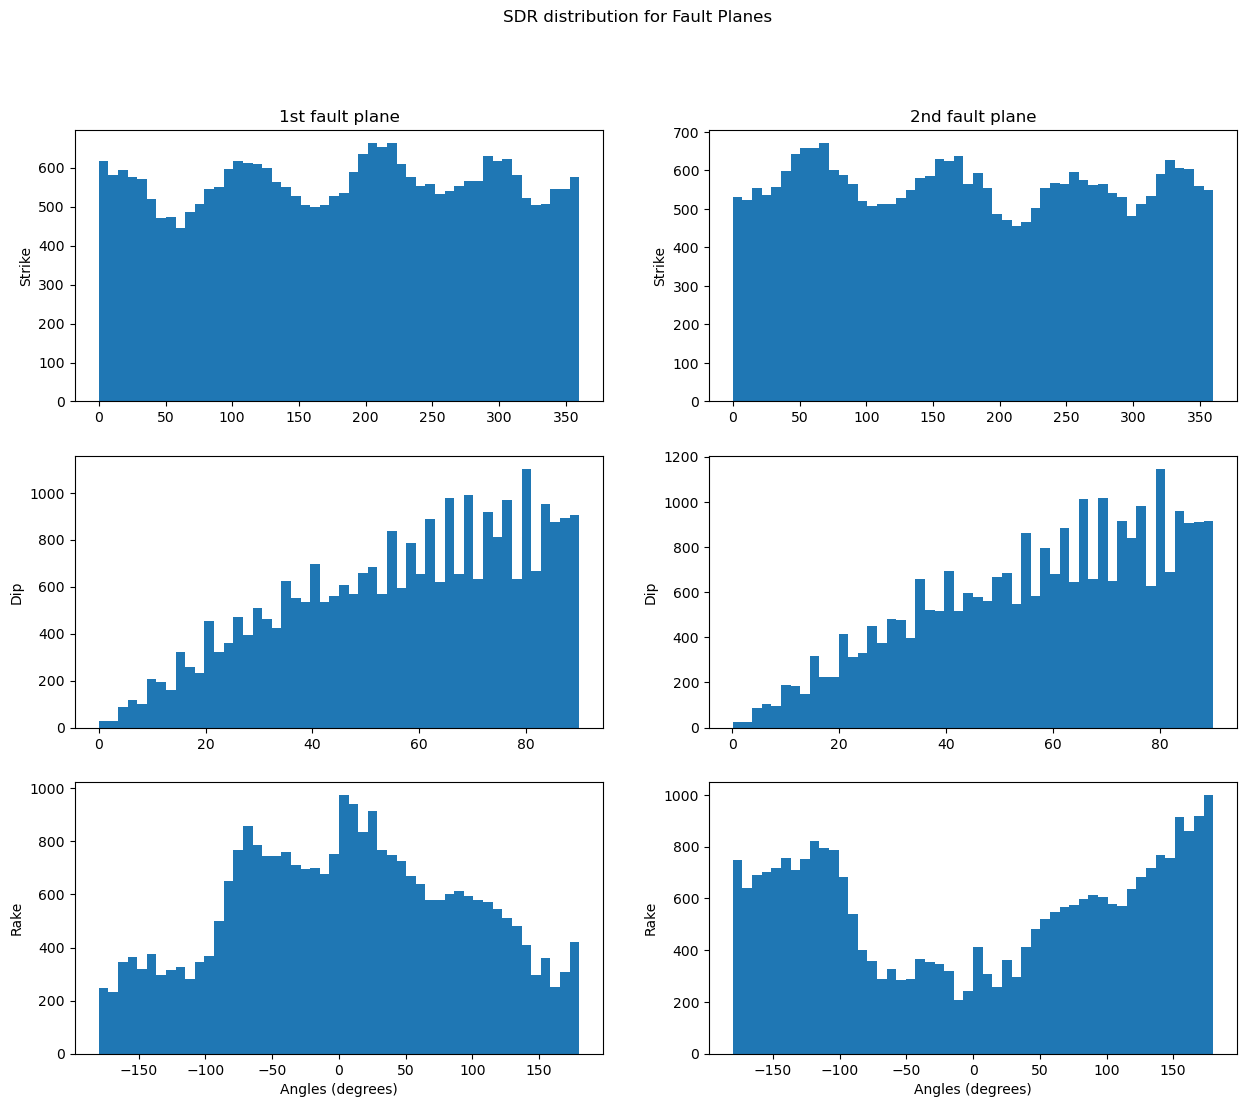

In [125]:
## GENERATING SAMPLES
# Don't use k_hat component for starting direction

"""
Explain the sinusoidal dip distribution
How does it influence grid search/predictions?
"""

# DEBUGGING
# Definitely not the hemisphere samples
# Still checking starting_direc, potential alternatives?

sdr1 = np.load("mysdr1_vec_rand.npy")
sdr2 = np.load("mysdr2_vec_rand.npy")

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([emt[i] for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([emt[i] for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [112]:
# I need a seed
"""
Run this too
"""
importlib.reload(fr)

dd = 1.5
t_samples = fr.rigid_hemisphere_samples(dd)
t_vec, p_vec = [], []
sdr1, sdr2 = [], []

for t in t_samples:
    # p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_rotations = np.arange(0, np.pi, np.deg2rad(dd))
    p_start = fr.starting_direc(t, fr.j_hat)
    # p_start = fr.perp(t)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        t_vec.append(t)
        p_vec.append(p)
        sdr1.append(np.rad2deg(sdr1_emt))
        sdr2.append(np.rad2deg(sdr2_emt))

np.save("t_vec_k.npy", t_vec)
np.save("p_vec_k.npy", p_vec)
np.save("sdr1_vec_k.npy", sdr1)
np.save("sdr2_vec_k.npy", sdr2)

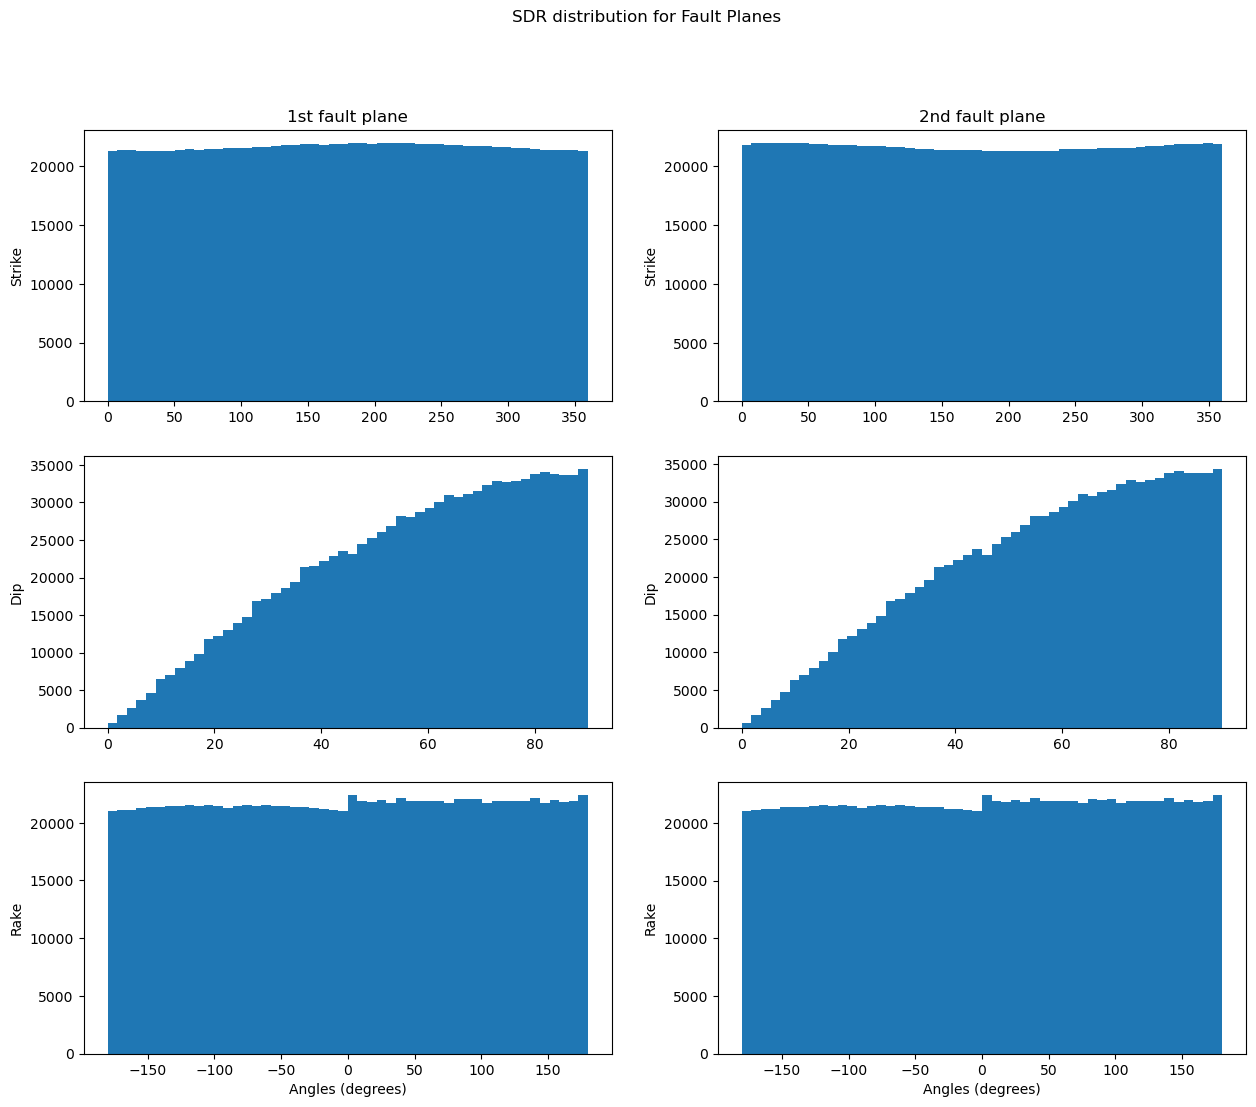

In [113]:
## GENERATING SAMPLES
# Don't use k_hat component for starting direction

"""
Explain the sinusoidal dip distribution
How does it influence grid search/predictions?
"""

# DEBUGGING
# Definitely not the hemisphere samples
# Still checking starting_direc, potential alternatives?

sdr1 = np.load("sdr1_vec_k.npy")
sdr2 = np.load("sdr2_vec_k.npy")

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([emt[i] for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([emt[i] for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [ ]:
## GENERATING SAMPLES
# Don't use k_hat component for starting direction

"""
Explain the sinusoidal dip distribution
How does it influence grid search/predictions?
"""

# DEBUGGING
# Definitely not the hemisphere samples
# Still checking starting_direc, potential alternatives?

sdr1 = np.load("sdr1_vec_k.npy")
sdr2 = np.load("sdr2_vec_k.npy")

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

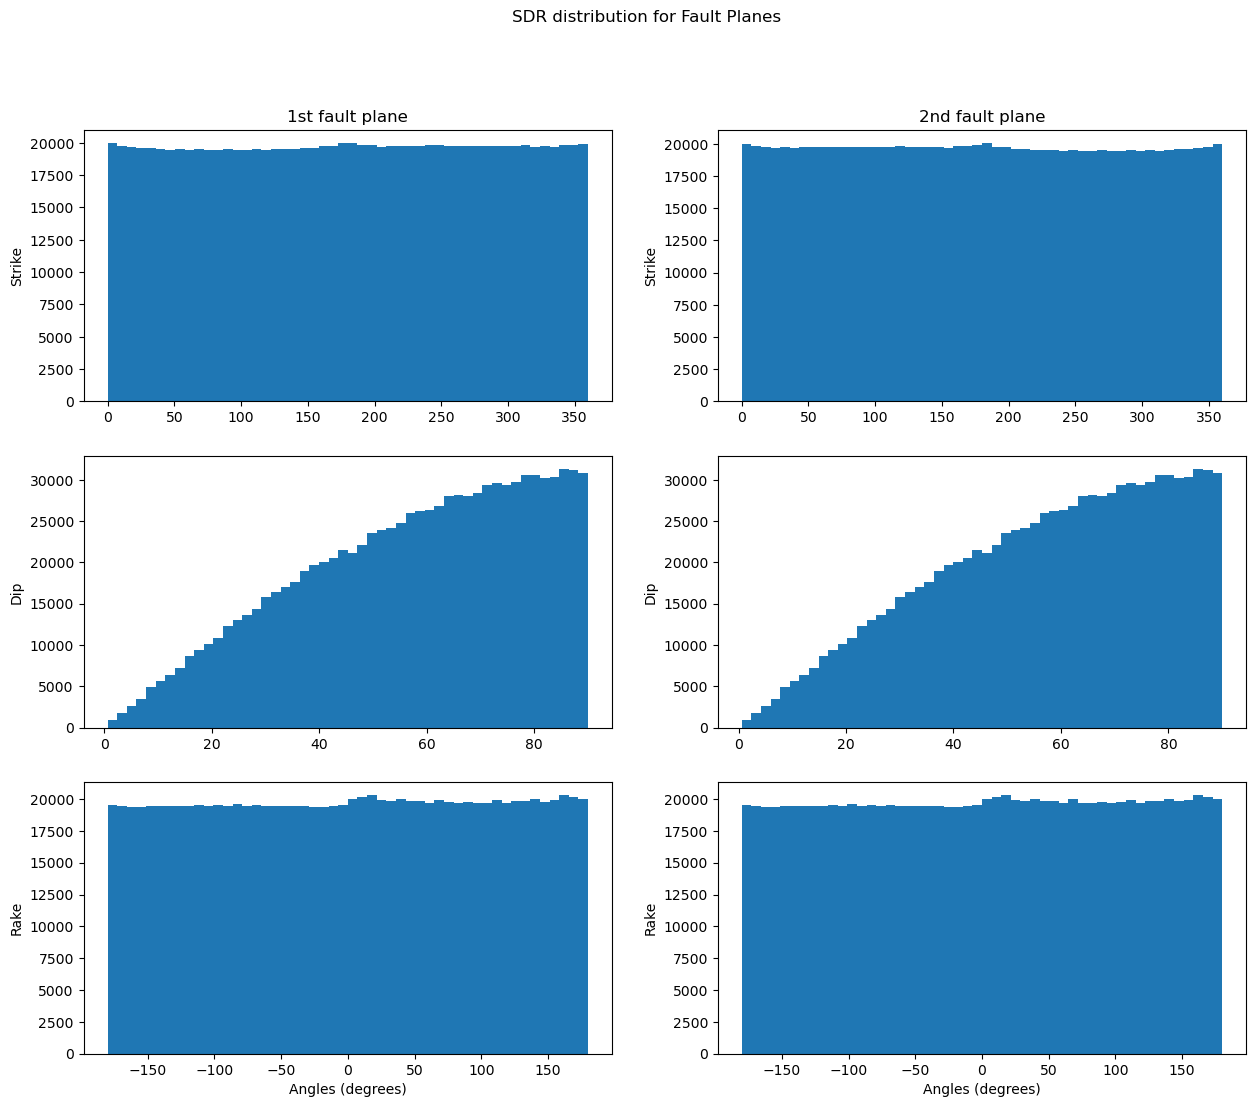

In [16]:
N = 40
t_samples = fr.rigid_hemisphere_samples(N)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, fr.i_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [ ]:
N = 40
t_samples = fr.rigid_hemisphere_samples(N)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, fr.i_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

c:\Users\18723\Documents\GitHub\SURG-Mars\function_repo.py:321: RuntimeWarning: invalid value encountered in divide
  return rem/np.linalg.norm(rem)


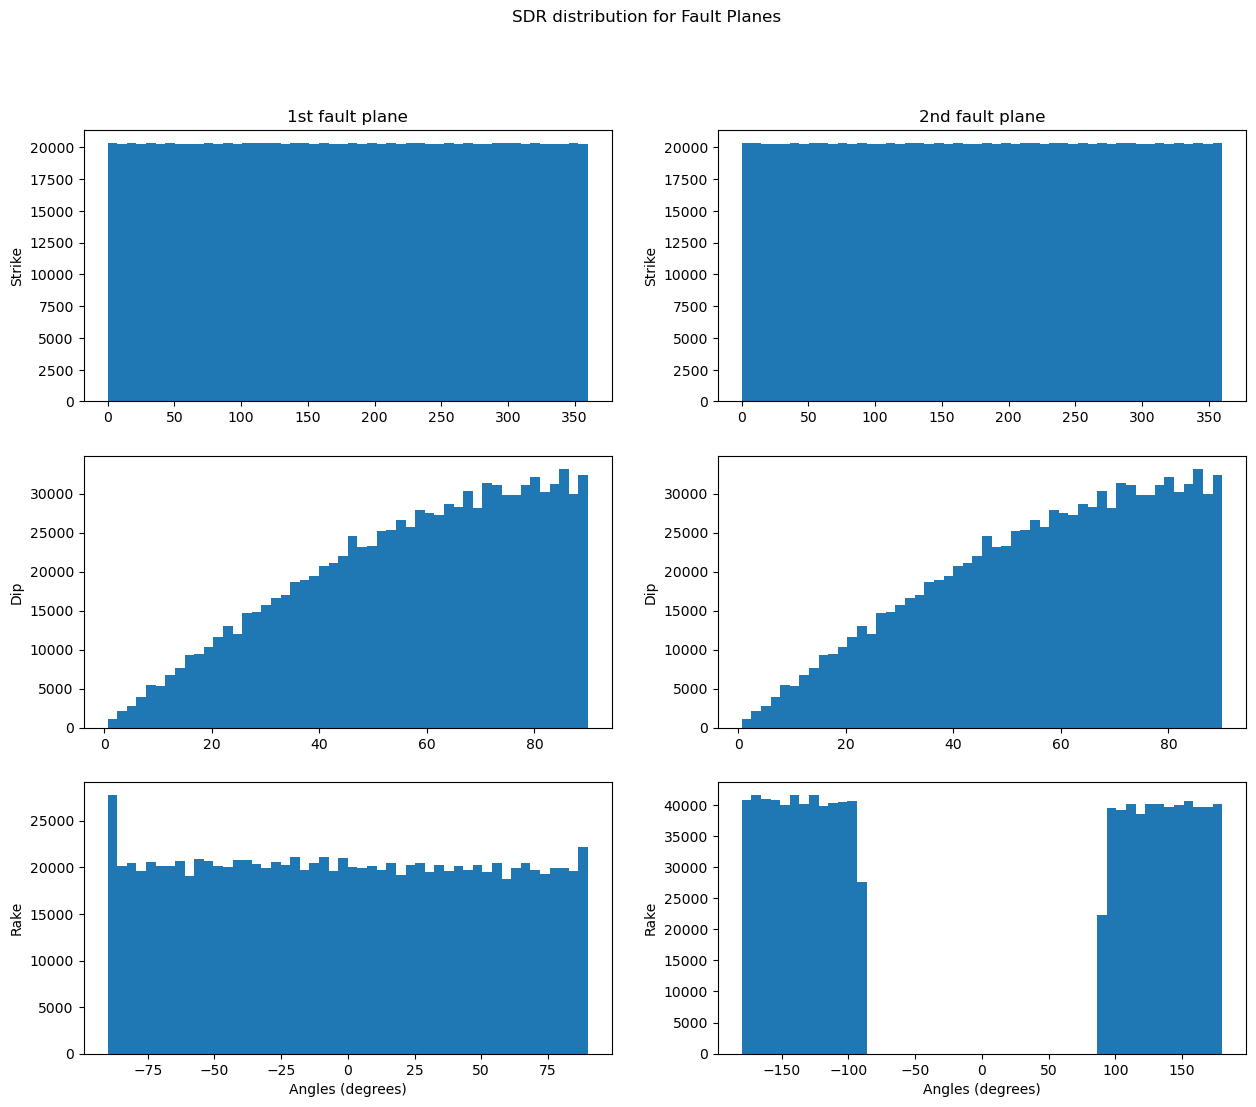

In [10]:
N = 40
t_samples = fr.rigid_hemisphere_samples(N)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, fr.k_hat)
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

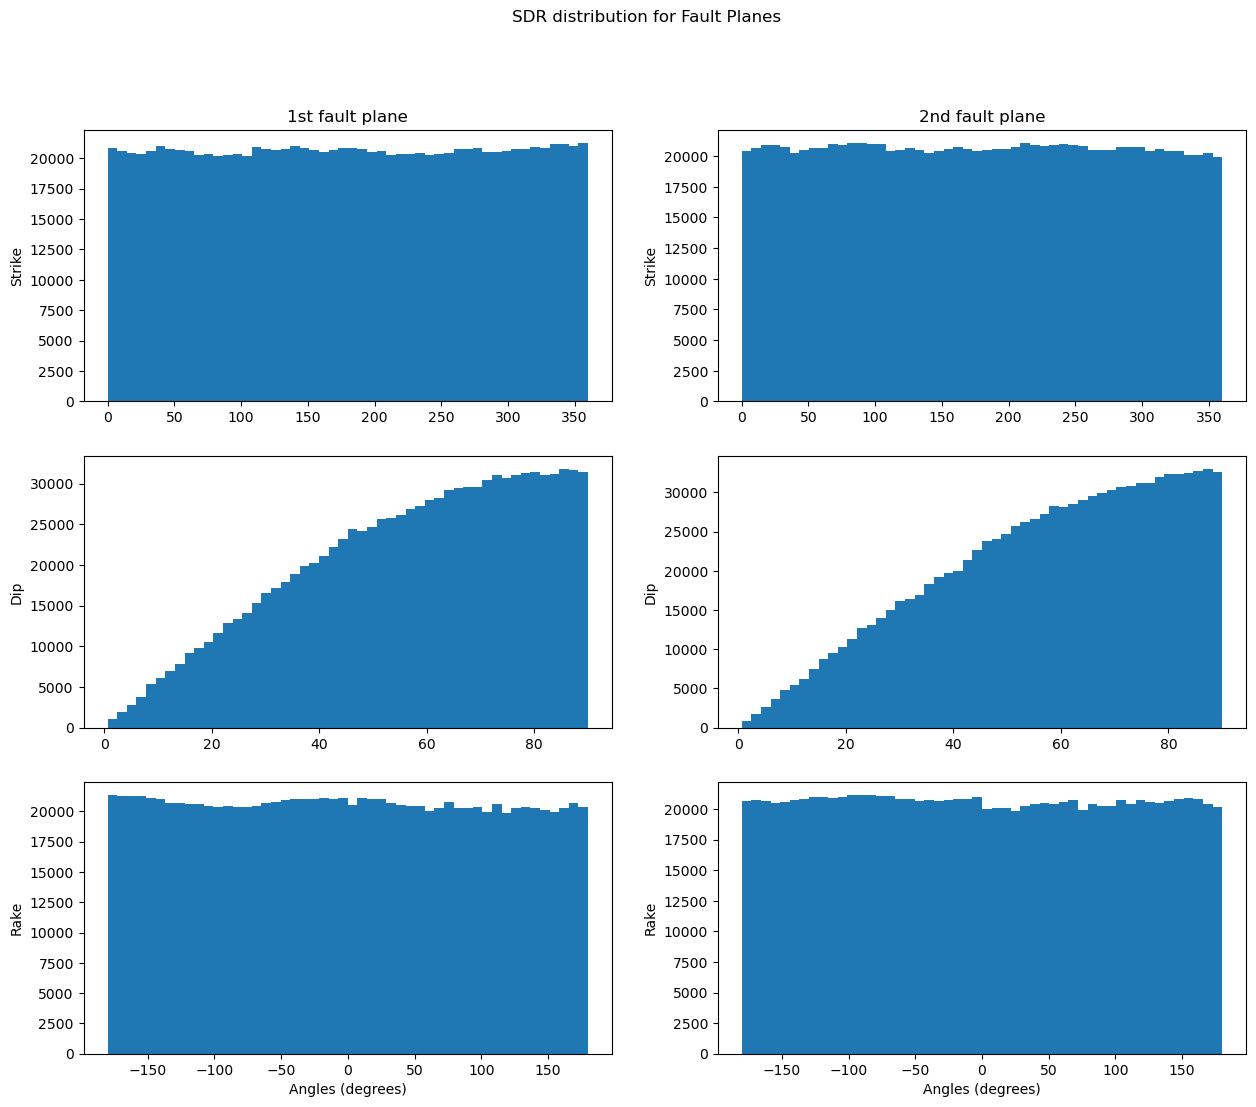

In [17]:
N = 40.2
t_samples = fr.rigid_hemisphere_samples(N)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, stats.norm.rvs(size=3))
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [ ]:
N = 40.2
t_samples = fr.rigid_hemisphere_samples(N)
sdr1 = []
sdr2 = []

for t in t_samples:
    p_rotations = np.linspace(0, np.pi, int(np.sqrt(len(t_samples))))
    p_start = fr.starting_direc(t, stats.norm.rvs(size=3))
    for theta in p_rotations:
        p = fr.rotate(p_start, t, theta)
        sdr1_emt, sdr2_emt = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
        sdr1.append(sdr1_emt)
        sdr2.append(sdr2_emt)

# Histograms for sdr1 and sdr2
fig1 = plt.figure(figsize=(15,12))
plt.suptitle("SDR distribution for Fault Planes")

ylabels = ["Strike", "Dip", "Rake"]

for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist([np.rad2deg(emt[i]) for emt in sdr1], bins=50)
    if i == 0: plt.title("1st fault plane")
    plt.ylabel(ylabels[i])
plt.xlabel("Angles (degrees)")

for i in range(3):
    plt.subplot(3,2,2*(i+1))
    plt.hist([np.rad2deg(emt[i]) for emt in sdr2], bins=50)
    if i == 0: plt.title("2nd fault plane")
    plt.ylabel(ylabels[i])
    
plt.xlabel("Angles (degrees)")
plt.show()

In [12]:

## TESTING PREDICTIVE POWER

"""
I want to save the results as a dataframe
Turn this into a function that returns a dataframe
given N, hdepth, epdist, azimuth, Ao, Uo and model
This is the main part of the show
"""

model = TauPyModel(model='ak135') # velocity model
hdepth = 15 # km - assumed quake depth
b3_over_a3 = (3.4600/5.8000)**3 # from Maddy's paper, not part of the velocity model
epdist = 10   # good estimate? - use wilbur3
# try 45 degrees
azimuth = 200 # arbitrary
N = 100 # number of samples per s-d pair

# fake an observation of amplitude + uncertainty (normal fault in this case)
# real data will have no known source mechanism
t, p = np.array([1,0,0]), np.array([0,0,1])
faults = fr.tp2sdr(fr.coord_switch(t), fr.coord_switch(p))
faults = np.rad2deg(np.array(faults))
print(faults)
# scale = stats.uniform.rvs(0.5,10) # necessary?
scale = 1
"""
Confirm scale
"""
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
Ao = np.array(fr.Rpattern(faults[0], azimuth, takeoff_angles))*scale
Ao[0] *= b3_over_a3 # Maddy's paper page 5, reread
sigma = 0.1
Uo = np.array([abs(Ao[i])*sigma for i in range(len(Ao))])
print(f"Observation: {Ao}\nUncertainty: {Uo}")
print(f"Ao: {Ao}")

[[  0.  45. -90.]
 [180.  45. -90.]]
Observation: [-0.09065779 -0.55019402  0.2459985 ]
Uncertainty: [0.00906578 0.0550194  0.02459985]
Ao: [-0.09065779 -0.55019402  0.2459985 ]


In [13]:
## DATAFRAME

# df = fr.apply_inverse_methods(model, "t_vec.npy", "p_vec.npy", "sdr1_vec.npy", "sdr2_vec.npy",
#                               hdepth, epdist, azimuth, Ao, Uo)
# df.to_csv("normal_fault_guess.csv", index=False)

In [31]:
# Create a dataframe that only includes weights up to 2 epsilon

# df = fr.apply_inverse_methods(model, "t_vec.npy", "p_vec.npy", "sdr1_vec.npy", "sdr2_vec.npy",
#                               hdepth, epdist, azimuth, Ao, Uo, True)
# df.to_csv("rigid_normal.csv", index=False)

In [36]:
# Create a dataframe that only includes weights up to 2 epsilon

# df = fr.apply_inverse_methods(model, "t_vec_rand.npy", "p_vec_rand.npy", "sdr1_vec_rand.npy", "sdr2_vec_rand.npy",
#                               hdepth, epdist, azimuth, Ao, Uo, True)
# df.to_csv("rigidish_normal.csv", index=False)

In [131]:
# Create a dataframe that only includes weights up to 2 epsilon

# See function_repo.py for parameters
df = fr.apply_inverse_methods(model, "myt_vec_rand.npy", "myp_vec_rand.npy", "mysdr1_vec_rand.npy", "mysdr2_vec_rand.npy",
                              hdepth, epdist, azimuth, Ao, Uo, True)
df.to_csv("rigid_rand_normal.csv", index=False)